In [1]:
!which python

/Users/itay/Documents/university/DataScience/venv/bin/python


In [2]:
import pandas as pd
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 
from tensorflow import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv("/Users/itay/Downloads/spx.csv", parse_dates=['date'], index_col='date')

In [4]:
sep = int(len(df)*0.95)
train, test = df.iloc[:sep], df.iloc[sep:]

train.shape, test.shape

((7782, 1), (410, 1))

In [5]:


scaler = StandardScaler()
scaler.fit(train[["close"]])

StandardScaler()

In [6]:
train.close = scaler.transform(train[["close"]])
test.close = scaler.transform(test[["close"]])
window = 30

/Users/itay/Documents/university/DataScience/venv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/itay/Documents/university/DataScience/venv/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
def create_database(df, window): 
    items = []
    for i, (s, e) in enumerate(zip(range(0,len(df)-window), range(window, len(df)))):
        items.append(df.values[s:e].ravel())
#     return items
    df_ = pd.DataFrame(items)
    X = df_[range(window)]
    return X.values.reshape(*X.shape, 1)
    

X_train = create_database(train, window)
X_test = create_database(test, window)

train.head(20)

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169
1986-01-09,-1.481663
1986-01-10,-1.481945
1986-01-13,-1.480517
1986-01-14,-1.480667


<AxesSubplot:xlabel='date', ylabel='close'>

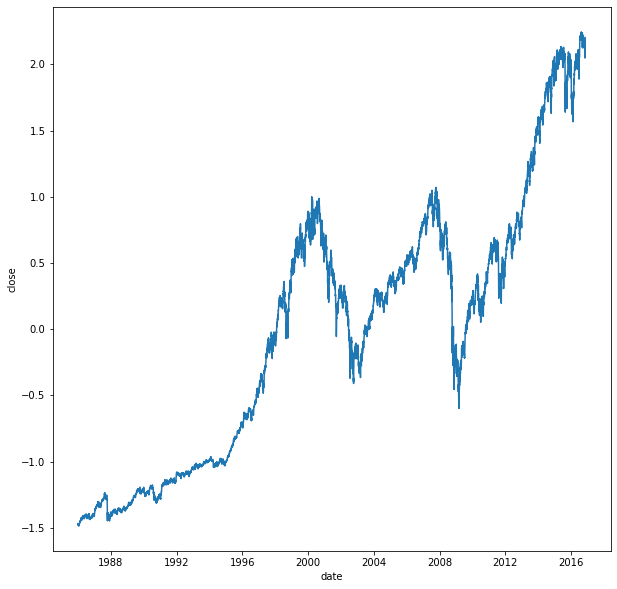

In [8]:
plt.figure(figsize=(10,10))
sns.lineplot(x="date", y="close", data=train.reset_index())


In [40]:
timesteps = X_train.shape[1]
features = X_train.shape[2]
inputs = layers.Input(shape = (timesteps, features))
l = layers.LSTM(units=32, dtype='float32')(inputs)
l = layers.Dropout(0.2)(l)
l = layers.RepeatVector(n=timesteps)(l)
l = layers.LSTM(units=32, return_sequences=True)(l)
outputs = l = layers.TimeDistributed(layers.Dense(units=1))(l)
model = Model(inputs = inputs, outputs=outputs)
model.summary()
model.compile(loss="mae", optimizer="adam")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_______________________________________________________

In [41]:
model.fit(X_train, X_train,batch_size=32,
          validation_split=0.1,
          epochs=6, shuffle=False)

Epoch 1/6
218/218 [==============================] - 4s 19ms/step - loss: 0.2259 - val_loss: 0.5017
Epoch 2/6
218/218 [==============================] - 3s 16ms/step - loss: 0.1384 - val_loss: 0.3713
Epoch 3/6
218/218 [==============================] - 4s 17ms/step - loss: 0.1583 - val_loss: 0.3642
Epoch 4/6
218/218 [==============================] - 4s 20ms/step - loss: 0.1824 - val_loss: 0.3155
Epoch 5/6
218/218 [==============================] - 4s 19ms/step - loss: 0.1604 - val_loss: 0.3424
Epoch 6/6
218/218 [==============================] - 4s 16ms/step - loss: 0.1660 - val_loss: 0.3554


In [11]:
pred = model.predict(x=X_test)
pred.shape

(380, 30, 1)

In [12]:

diffs = np.mean(np.abs(pred - X_test), axis=1)

<AxesSubplot:>

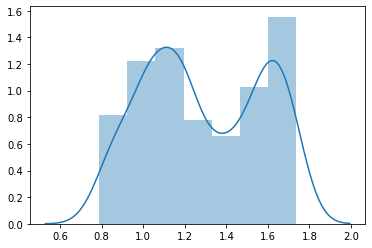

In [13]:

sns.distplot(diffs)

In [33]:
threshold = np.percentile(np.abs(pred - X_test), [95.0])

In [34]:
anomalies = (np.abs(pred - X_test) > threshold)

In [35]:
anomalies = anomalies[:,-1,0]

In [36]:
anomalies.shape, test.shape

((380,), (410, 1))

In [37]:
print(f"Found {np.count_nonzero(anomalies)} anomalies of {len(anomalies)} events")

Found 25 anomalies of 380 events


<AxesSubplot:xlabel='date', ylabel='close'>

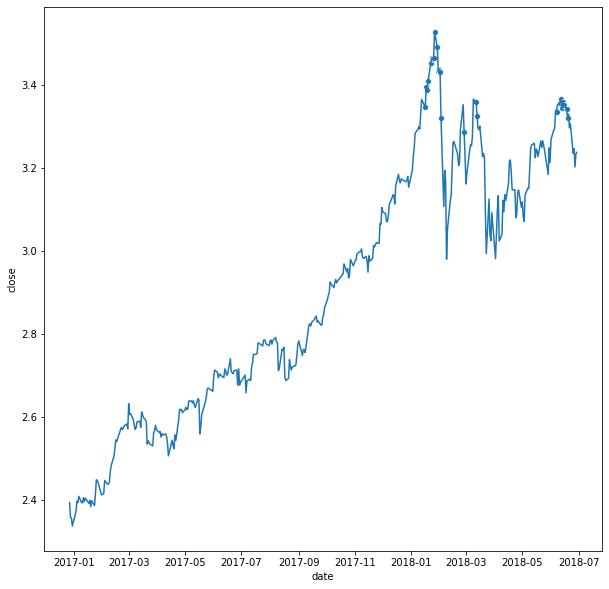

In [38]:
y_test = test.iloc[window:].assign(anomaly=anomalies).reset_index()
plt.figure(figsize=(10,10))
sns.lineplot(x="date", y='close', data=y_test, ci="sd", dashes=False)
sns.scatterplot(x="date", y="close", data=y_test[y_test.anomaly],)

In [20]:
y_test.assign(anomaly=anomalies)[anomalies]

,date,close,anomaly
207,2017-10-23,2.948977,True
212,2017-10-30,2.963722,True
214,2017-11-01,2.975987,True
215,2017-11-02,2.976908,True
216,2017-11-03,2.991915,True
...,...,...,...
375,2018-06-25,3.234646,True
376,2018-06-26,3.245897,True
377,2018-06-27,3.201889,True
378,2018-06-28,3.233219,True
